# Import of Modules and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_excel("./data/data_file.ods")
df.drop(columns = {"Idea Title", "Idea Description"}, inplace = True)

## Number of Ideas and Assessors

In [3]:
print(df["Idea"].nunique())
print(df["Assessor"].nunique())

149
163


# Data Cleaning

In [4]:
#df.head()

In [5]:
#df.describe()

In [6]:
df["Flagged_Bool"] = df["Flagged"] == "x"
by_flag = df.groupby("Flagged_Bool")
#by_flag.get_group(True)

In [7]:
df.drop(labels="Flagged", inplace=True, axis=1)

In [8]:
df["Outcome"].fillna("JUSTIFIED", inplace = True)
#df["Outcome"].unique()

In [9]:
df.rename(columns={"Sum of Rating": "Sum of Reviews", "Ratings Done":"Number of Reviews"}, inplace=True)

In [10]:
df.head()

,Idea,Challenge,Category,Outcome,Sum of Reviews,Number of Reviews,Rating Given,Assessor,Assessment Note,Flagged_Bool
0,a better catalyst,CC,Success Chance,DISPUTED,-1,3,1,103,The proposal doesn't contain any execution pla...,False
1,a better catalyst,CC,Success Chance,JUSTIFIED,2,2,1,104,Due to all changes will might take place in th...,False
2,a better catalyst,CC,Success Chance,JUSTIFIED,0,0,1,116,NaN,False
3,a better catalyst,CC,Success Chance,JUSTIFIED,0,0,1,117,NaN,False
4,a better catalyst,CC,Success Chance,JUSTIFIED,1,1,1,118,No information has been provided by the propos...,False


### Define Unjustified and Disputed Category

Unjustified: At least 3 

In [11]:
df["Unjustified"] = (df["Outcome"] == "UNJUSTIFIED") & (df["Number of Reviews"] >= 2)

In [12]:
df["Disputed"] = (df["Outcome"] == "DISPUTED") & (df["Number of Reviews"] >= 2) & (df["Sum of Reviews"] < 0)

In [13]:
df.head()

,Idea,Challenge,Category,Outcome,Sum of Reviews,Number of Reviews,Rating Given,Assessor,Assessment Note,Flagged_Bool,Unjustified,Disputed
0,a better catalyst,CC,Success Chance,DISPUTED,-1,3,1,103,The proposal doesn't contain any execution pla...,False,False,True
1,a better catalyst,CC,Success Chance,JUSTIFIED,2,2,1,104,Due to all changes will might take place in th...,False,False,False
2,a better catalyst,CC,Success Chance,JUSTIFIED,0,0,1,116,NaN,False,False,False
3,a better catalyst,CC,Success Chance,JUSTIFIED,0,0,1,117,NaN,False,False,False
4,a better catalyst,CC,Success Chance,JUSTIFIED,1,1,1,118,No information has been provided by the propos...,False,False,False


In [14]:
assessor_stats = df[["Assessor", "Assessment Note"]].groupby("Assessor").count().rename(
        columns={"Assessment Note":"Filled Notes"})
assessor_stats["Total Entries"] = df[["Assessor", "Assessment Note"]].groupby("Assessor").size()
assessor_stats["Empty"] = assessor_stats["Total Entries"] - assessor_stats["Filled Notes"]
assessor_stats["Empty Rate"] = assessor_stats["Empty"] / assessor_stats["Total Entries"]

In [15]:
assessor_stats["Unjustified"] = df[["Assessor", "Unjustified"]].groupby("Assessor").any()
assessor_stats["Disputed"] = df[["Assessor", "Outcome"]].groupby("Assessor").any()

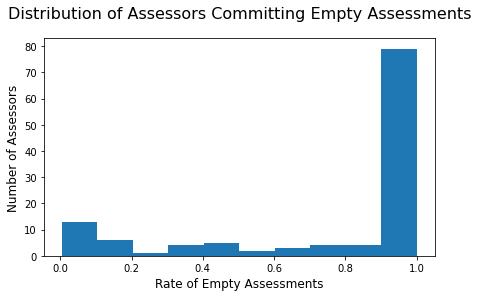

In [16]:
assessors_with_empty_notes = assessor_stats["Empty Rate"] != 0

f, ax = plt.subplots(1, figsize=(7,4))
data = assessor_stats["Empty Rate"][assessors_with_empty_notes]
bins = 10
ax.hist(data, bins)
ax.set_ylim(bottom=0)

ax.set_xlabel("Rate of Empty Assessments", fontsize=12)
ax.set_ylabel("Number of Assessors", fontsize=12)
ax.set_title("Distribution of Assessors Committing Empty Assessments", fontsize=16, pad=20)
plt.show(f)
f.savefig("historgram_empty_rate.png")

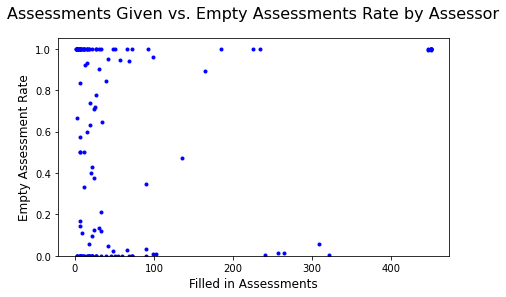

In [17]:
f, ax = plt.subplots(1, figsize=(7,4))
xdata = assessor_stats["Total Entries"]
ydata = assessor_stats["Empty Rate"]
ax.plot(xdata, ydata, marker='.', color='b', linestyle='')
ax.set_ylim(bottom=0)

ax.set_xlabel("Filled in Assessments", fontsize=12)
ax.set_ylabel("Empty Assessment Rate", fontsize=12)
ax.set_title("Assessments Given vs. Empty Assessments Rate by Assessor", fontsize=16, pad=20)
plt.show(f)
f.savefig("scatter_empty_rate.png")

## Categorise the Assessors by their contributions

In [18]:
df_empty = df[df["Assessment Note"].isnull()]
df_non_empty = df[df["Assessment Note"].notnull()]

In [19]:
assessors = df["Assessor"].unique()
assessor_empty = df_empty["Assessor"].unique()
assessor_non_empty = df_non_empty["Assessor"].unique()

In [20]:
assessor_sometimes_empty = np.intersect1d(assessor_empty, assessor_non_empty)

In [21]:
assessor_always_empty = [assessor for assessor in assessor_empty if assessor not in assessor_sometimes_empty]

In [22]:
unfair_raw = df_non_empty["Assessor"][df_non_empty["Unjustified"]].unique()
unfair_mask = np.isin(unfair_raw,assessor_empty, invert = True)

assessor_unfair = unfair_raw[unfair_mask]

In [23]:
disputed_raw = df_non_empty["Assessor"][df_non_empty["Disputed"]].unique()
disputed_mask = np.isin(disputed_raw, assessor_unfair, invert = True) & np.isin(disputed_raw, assessor_empty, invert = True)

assessor_disputed = disputed_raw[disputed_mask]

In [24]:
assessor_all_unfair = np.union1d(assessor_empty, assessor_unfair)

assessor_fair = [assessor for assessor in assessors if assessor not in assessor_all_unfair]
assessor_undisputed = [assessor for assessor in assessor_fair if assessor not in assessor_disputed]

In [25]:
print("Empty: %d" % len(assessor_empty))
print("Not Empty: %d" % len(assessor_non_empty))
print("Always Empty: %d" % len(assessor_always_empty))
print("Sometimes Empty: %d" % len(assessor_sometimes_empty))
print("Unfair: %d" % len(assessor_unfair))
print("Fair: %d" % len(assessor_fair))
print("Disputed: %d" % len(assessor_disputed))
print("Undisputed: %d" % len(assessor_undisputed))

Empty: 121
Not Empty: 93
Always Empty: 70
Sometimes Empty: 51
Unfair: 1
Fair: 41
Disputed: 9
Undisputed: 32


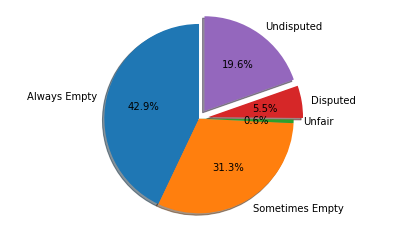

In [26]:
labels = "Always Empty", "Sometimes Empty", "Unfair", "Disputed", "Undisputed"
sizes = [len(assessor_always_empty)
         , len(assessor_sometimes_empty)
         , len(assessor_unfair)
         , len(assessor_disputed)
        , len(assessor_undisputed)]
explode = (0, 0, 0, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(7,4))
ax1.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
fig1.savefig("assessor_distribution.png")

In [31]:
assessor_less_10p_empty = assessor_stats["Empty Rate"] < 0.1

In [32]:
assessor_less_10p_disputed = assessor_stats["Empty Rate"] < 0.1

In [33]:
assessor_stats["Filled Notes"][assessors_with_empty_notes & assessor_less_10p_empty].sum()

1836

## Impact on Assessor Categorization on Assessments

In [34]:
empty = df_empty["Idea"].count()
empty_collateral = df_non_empty["Idea"][df_non_empty["Assessor"].isin(assessor_sometimes_empty)].count()
unfair_collateral = df_non_empty["Idea"][df_non_empty["Assessor"].isin(assessor_unfair)].count()
disputed = df_non_empty["Idea"][df_non_empty["Disputed"]].count()

fair = df["Rating Given"].count() - empty - empty_collateral - unfair_collateral - disputed

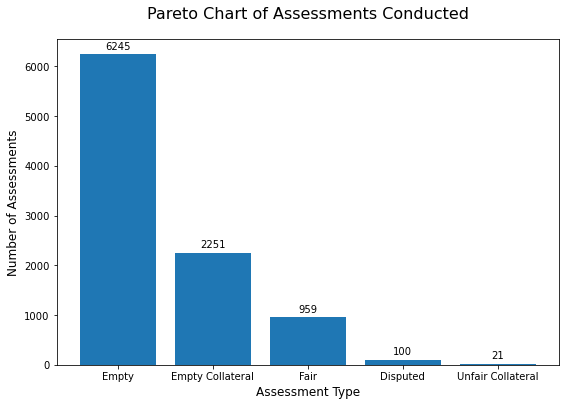

In [38]:
f, ax = plt.subplots(1, figsize=(9,6))

labels = ["Empty", "Empty Collateral", "Fair", "Disputed", "Unfair Collateral"]
x = np.arange(len(labels))
assessments = [empty, empty_collateral, fair, disputed, unfair_collateral]

bar1 = ax.bar(x, assessments)

ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(bars):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)

ax.set_xlabel("Assessment Type", fontsize=12)
ax.set_ylabel("Number of Assessments", fontsize=12)
ax.set_title("Pareto Chart of Assessments Conducted", fontsize=16, pad=20)
plt.show(f)
f.savefig("pareto.png")

## Undisputed Assessments
All assessments, that are not collateral, have a positive sum of rating or less than 3 ratings done

In [39]:
#undisputed_mask = df_non_empty["Disputed"] or df_non_empty["Unjustified"]
#df_undisputed = df_non_empty[undisputed_mask]

In [40]:
#df_undisputed.head()

In [41]:
avg_ratings = df[["Idea","Rating Given"]].groupby("Idea").mean().rename(columns={"Rating Given":"All"})
avg_ratings["Empty Notes"] = df_empty[["Idea", "Rating Given"]].groupby("Idea").mean()
avg_ratings["Filled Notes"] = df_non_empty[["Idea", "Rating Given"]].groupby("Idea").mean()

fair_mask = df_non_empty["Assessor"].isin(assessor_fair)
avg_ratings["Fair"] = df_non_empty[fair_mask][["Idea", "Rating Given"]].groupby("Idea").mean()
avg_ratings.head()

,All,Empty Notes,Filled Notes,Fair
Idea,,,,
A for ADA Cryptoalphabet 4 children,2.263158,2.333333,2.185185,2.333333
ABCD,4.000000,3.955556,4.074074,4.444444
ADA Epoch Clock,1.352941,1.428571,1.260870,1.333333
ADA MakerSpace - DEV lessons,4.148148,4.279070,4.000000,4.750000
ADA in 4000 Crypto ATMs Globally!,2.904762,3.055556,2.703704,3.555556


In [42]:
avg_ratings["Count All"] = df[["Idea","Rating Given"]].groupby("Idea").count()
avg_ratings["Count Empty Notes"] = df_empty[["Idea", "Rating Given"]].groupby("Idea").count()
avg_ratings["Count Filled Notes"] = df_non_empty[["Idea", "Rating Given"]].groupby("Idea").count()

fair_mask = df_non_empty["Assessor"].isin(assessor_fair)
avg_ratings["Count Fair"] = df_non_empty[fair_mask][["Idea", "Rating Given"]].groupby("Idea").count()
avg_ratings["Shift Ratio"] = avg_ratings["Fair"] / avg_ratings["All"]
avg_ratings.head()

,All,Empty Notes,Filled Notes,Fair,Count All,Count Empty Notes,Count Filled Notes,Count Fair,Shift Ratio
Idea,,,,,,,,,
A for ADA Cryptoalphabet 4 children,2.263158,2.333333,2.185185,2.333333,57,30,27,9.0,1.031008
ABCD,4.000000,3.955556,4.074074,4.444444,72,45,27,9.0,1.111111
ADA Epoch Clock,1.352941,1.428571,1.260870,1.333333,51,28,23,12.0,0.985507
ADA MakerSpace - DEV lessons,4.148148,4.279070,4.000000,4.750000,81,43,38,12.0,1.145089
ADA in 4000 Crypto ATMs Globally!,2.904762,3.055556,2.703704,3.555556,63,36,27,9.0,1.224044


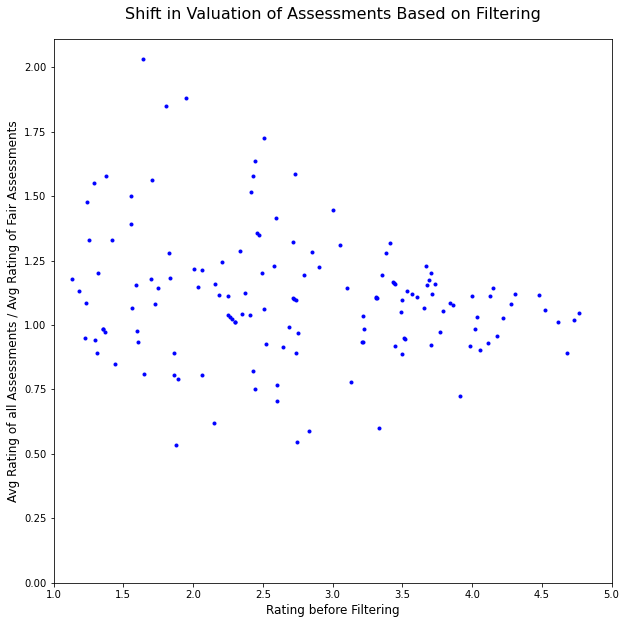

In [43]:
f, ax = plt.subplots(1, figsize=(10,10))
xdata = avg_ratings["All"]
ydata = avg_ratings["Shift Ratio"]
ax.plot(xdata, ydata, marker='.', color='b', linestyle='')
ax.set_ylim(bottom=0)
ax.set_xlim([1,5])

ax.set_xlabel("Rating before Filtering", fontsize=12)
ax.set_ylabel("Avg Rating of all Assessments / Avg Rating of Fair Assessments", fontsize=12)
ax.set_title("Shift in Valuation of Assessments Based on Filtering", fontsize=16, pad=20)
plt.show(f)
f.savefig("rating_shift.png")

NameError: name 'matplotlib' is not defined

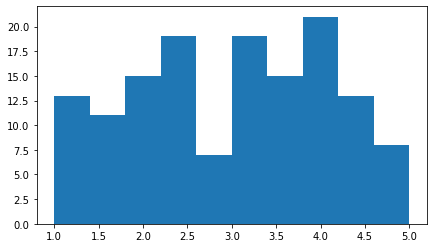

In [55]:
f, ax = plt.subplots(1, figsize=(7,4))
data = avg_ratings["Fair"]
bins = 10
ax.hist(data, bins)
ax.set_ylim(bottom=0)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("Average Proposal Rating", fontsize=12)
ax.set_ylabel("Number of Proposals", fontsize=12)
ax.set_title("Distribution of Proposals by Rating", fontsize=16, pad=20)
plt.show(f)
f.savefig("Proposal_distribution.png")

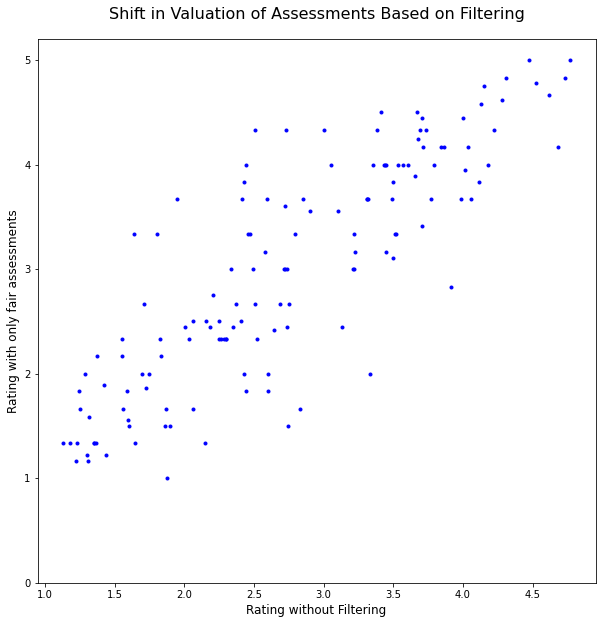

In [37]:
f, ax = plt.subplots(1, figsize=(10,10))
xdata = avg_ratings["All"]
ydata = avg_ratings["Fair"]
ax.plot(xdata, ydata, marker='.', color='b', linestyle='')
ax.set_ylim(bottom=0)

ax.set_xlabel("Rating without Filtering", fontsize=12)
ax.set_ylabel("Rating with only fair assessments", fontsize=12)
ax.set_title("Shift in Valuation of Assessments Based on Filtering", fontsize=16, pad=20)
plt.show(f)
f.savefig("shift_rating2.png")